# NST modificando DETALLES

In [1]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

import tensorflow as tf

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


In [3]:
# install tensorflow_hub
content_image = PIL.Image.open('valencia.png')
style_image = PIL.Image.open('oxford.png')

Imsize = 200

In [4]:
content_image = np.asarray(content_image.resize((Imsize,Imsize)))
style_image = np.asarray(style_image.resize((Imsize,Imsize)))

In [5]:
content_image = content_image[:,:,0:3].astype(np.float32)/255
style_image = style_image[:,:,0:3].astype(np.float32)/255

style_image.shape

(200, 200, 3)

In [6]:
content_image = np.expand_dims(content_image,0)
style_image = np.expand_dims(style_image,0)
content_image.shape

(1, 200, 200, 3)

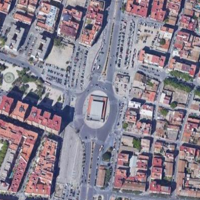

In [7]:
tensor_to_image(content_image[0,:,:,:])

## Construir modelo

In [8]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


### Construye el modelo

In [9]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [10]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()


80134624/80134624 [==============================] - 1s 0us/step
block1_conv1
  shape:  (1, 200, 200, 64)
  min:  0.0
  max:  728.4817
  mean:  27.123232

block2_conv1
  shape:  (1, 100, 100, 128)
  min:  0.0
  max:  2988.7854
  mean:  180.43889

block3_conv1
  shape:  (1, 50, 50, 256)
  min:  0.0
  max:  6730.1504
  mean:  169.59895

block4_conv1
  shape:  (1, 25, 25, 512)
  min:  0.0
  max:  16111.312
  mean:  592.8773

block5_conv1
  shape:  (1, 12, 12, 512)
  min:  0.0
  max:  1948.7212
  mean:  42.644035



### Calcular estilo

In [11]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


### Extraer estilo y contenido

In [12]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [13]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.009272274
    max:  15027.632
    mean:  779.51807

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  276102.9
    mean:  29934.062

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  927739.9
    mean:  29365.727

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  10294752.0
    mean:  335908.38

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  239529.25
    mean:  1964.2351

Contents:
   block5_conv2
    shape:  (1, 12, 12, 512)
    min:  0.0
    max:  710.5966
    mean:  17.308922


### Ejecutar descenso de gradiente

In [14]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [15]:
image = tf.Variable(content_image)

In [16]:
def clip_0_1(image):
      return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.optimizers.Adam(learning_rate=0.1, beta_1=0.99, epsilon=1e-1)

In [18]:
# WEIGHTS
# style_weight=1e-10 # ERROR de 3
# content_weight=1e-3  # ERROR de 3

style_weight=1e-8
content_weight=1e-4
image = tf.Variable(content_image)

In [19]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss

    return loss, style_loss, content_loss


In [20]:
loss, style_loss, content_loss = style_content_loss(extractor(content_image))
print(np.array(loss), np.array(style_loss), np.array(content_loss))

loss, style_loss, content_loss = style_content_loss(extractor(style_image))
print(np.array(loss), np.array(style_loss), np.array(content_loss))

242.3397 242.3397 0.0
0.28684404 0.0 0.28684404


In [21]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


In [22]:
# train_step(image)
# train_step(image)

L_cont = np.array([])
L_style = np.array([])

for n in range(0,2000):
    train_step(image)

    outputs = extractor(image)
    loss, style_loss, content_loss = style_content_loss(outputs)
    print(np.array(loss), np.array(style_loss), np.array(content_loss))
    L_cont = np.append(L_cont,np.array(content_loss))
    L_style = np.append(L_style,np.array(style_loss))
    print(n)
# tensor_to_image(image[0,:,:,:])

95.02272 94.982544 0.040176377
0
78.66765 78.5759 0.09174737
1
73.36444 73.24259 0.121847995
2
64.57718 64.43825 0.1389281
3
57.98735 57.83695 0.15040208
4
56.97167 56.813698 0.15796869
5
56.63311 56.47211 0.16099869
6
51.16155 51.002254 0.15929505
7
41.9891 41.833652 0.15544808
8
34.49055 34.33843 0.15212286
9
30.864899 30.714874 0.15002356
10
29.807552 29.658703 0.14884937
11
29.177786 29.029306 0.14848016
12
27.77336 27.624254 0.14910507
13
25.663485 25.512526 0.1509596
14
23.720016 23.565765 0.15425102
15
22.657866 22.499159 0.15870689
16
22.597034 22.433588 0.16344616
17
22.930851 22.763035 0.16781549
18
22.776304 22.605042 0.17126325
19
21.673649 21.500347 0.17330259
20
19.93606 19.76192 0.17413905
21
18.228678 18.054352 0.1743255
22
17.050106 16.876019 0.17408682
23
16.46798 16.293924 0.1740556
24
16.200762 16.026327 0.1744349
25
15.946142 15.770824 0.175318
26
15.557119 15.380456 0.17666379
27
15.079537 14.901 0.17853767
28
14.696446 14.515649 0.18079771
29
14.574634 14.391352 

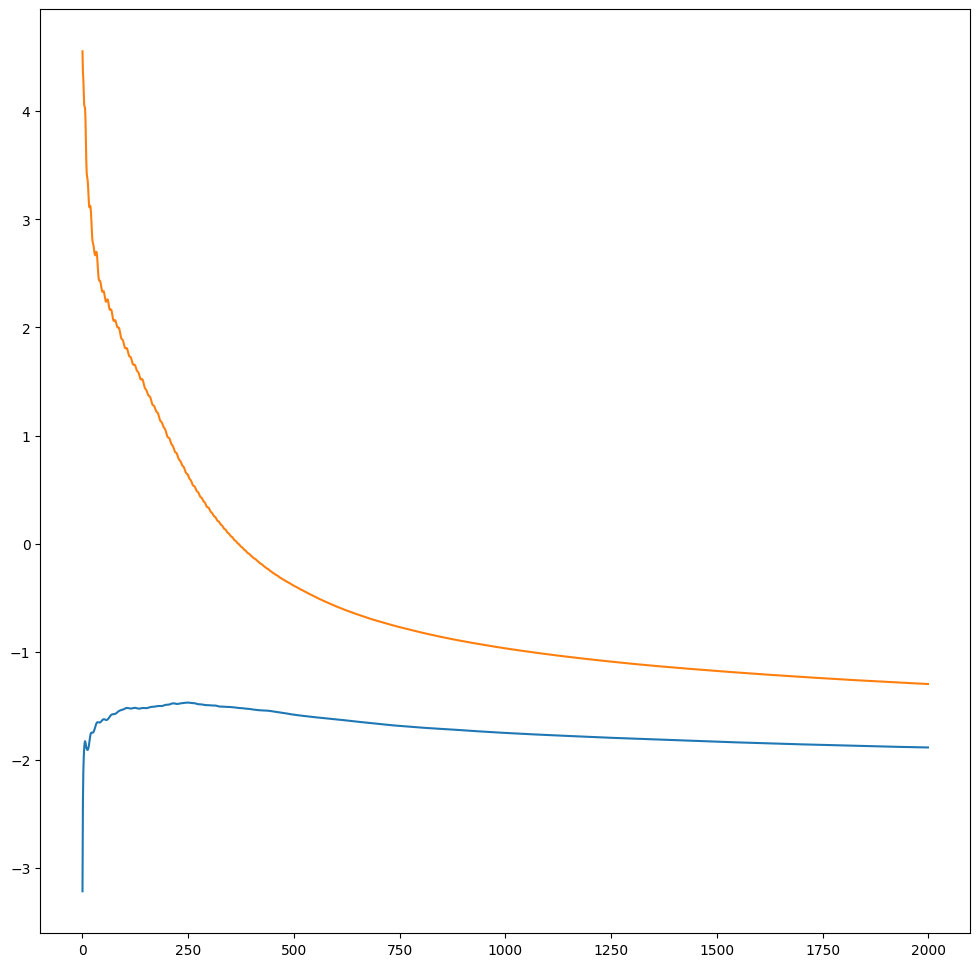

In [23]:
plt.plot(np.log(L_cont))
plt.plot(np.log(L_style))

In [24]:
def plot_images(content_image, style_image, image):
    plt.subplot(1,3,1)
    plt.title("Content image")
    plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title("Style image")
    plt.imshow(style_image[0, :,:,:],vmin=0,vmax=1)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title("Style-transfer image")
    plt.imshow(image[0, :,:,:],vmin=0,vmax=1)
    plt.axis('off')

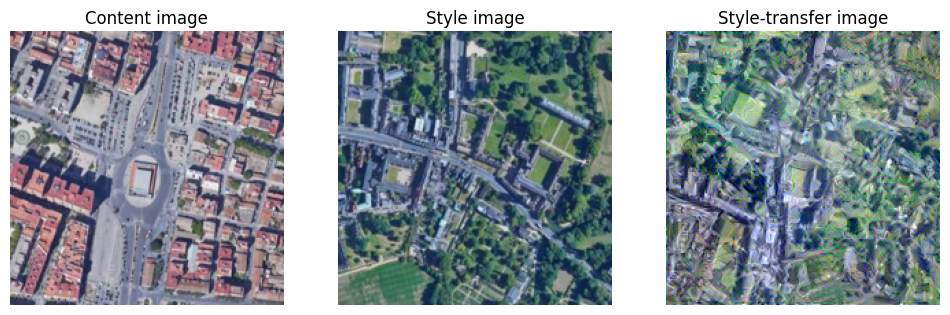

In [25]:

plot_images(content_image, style_image, image)